# Final Project - Churn Prediction

In this project we will be working with telecomunication company data to predict custumers who are about to leave.<br>
We will use personal data, and internal data to predict the target - 'EndDate' feature, indicating 'No' for custumers who didn't leave the company, and date of leaving.<br>
Our evalution matrics will be ROC-AUC as the predicting power for different tresheholds.

In [1]:
#!pip install missingno
#!pip install imbalanced-learn

In [2]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

#Error ignore
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
#Contract data
try:
    contract = pd.read_csv('C:/Users/vital/Downloads/final_provider/final_provider/contract.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    
#Internet data    
try:
    internet = pd.read_csv('C:/Users/vital/Downloads/final_provider/final_provider/internet.csv')
except:
    internet = pd.read_csv('/datasets/final_provider/internet.csv')

#Personal data
try:
    personal = pd.read_csv('C:/Users/vital/Downloads/final_provider/final_provider/personal.csv')
except:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    
#Phone data 
try:
    phone = pd.read_csv('C:/Users/vital/Downloads/final_provider/final_provider/phone.csv')
except:
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

We have 4 tables of data. We will exemine their content, missing values, duplicates and data types.

## Contracts

In [4]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


- Total charges seems to be the overall charge of the customer for all periods.
- The contract information is valid as of February 1, 2020.

When the period from start date until Feb, 2020 is longer we would expect higher Total charges.

In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
contract.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,5,No,5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043,6531,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


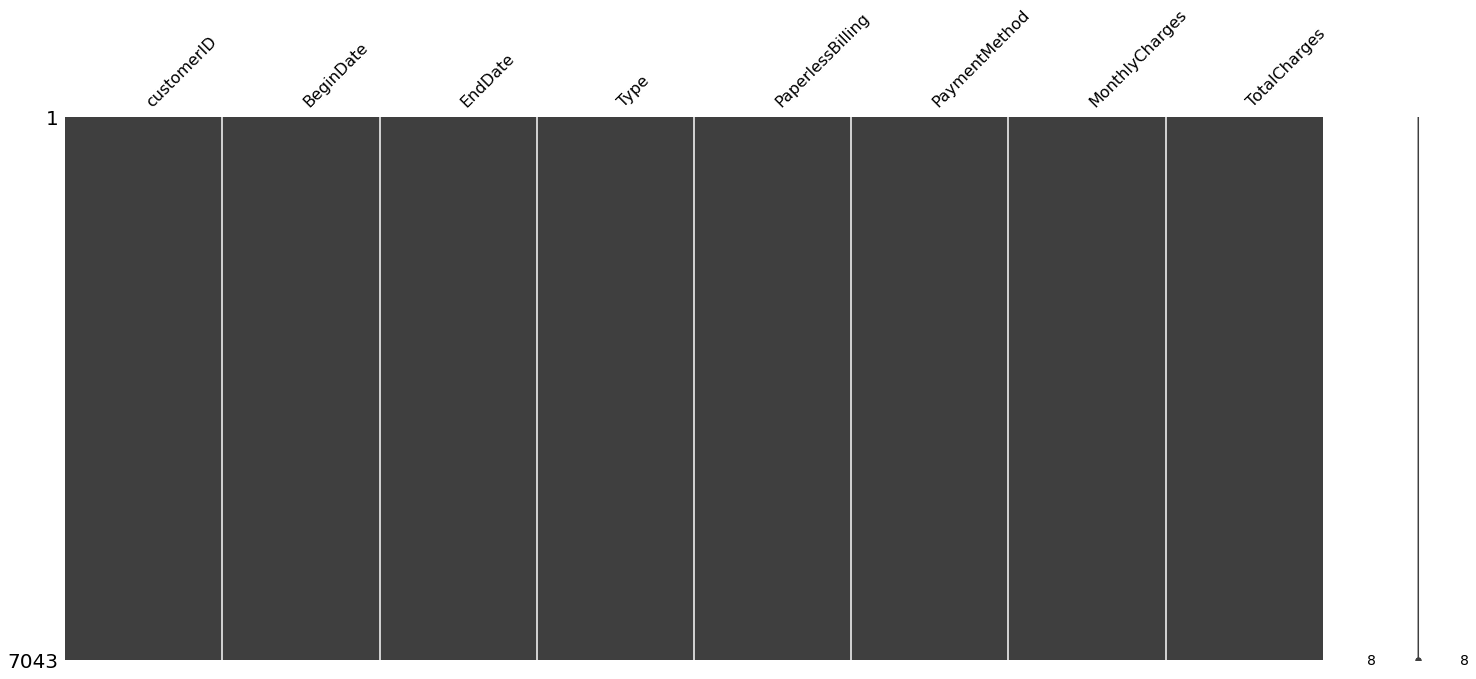

In [7]:
#Look at missing values
msno.matrix(contract);

No missing values

### Contract - findings

1. Customer ID is a unique feature.
2. BeginDate - need to be converted into datetime
3. EndDate - is a target variable. Need to convert to boolean type 1 and 0. Create new feaure for that. 
4. TotalCharge - need to be converted to float
5. We should add seniority

In [8]:
#converted into datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

In [9]:
#convert to boolian type 1 and 0
contract['target'] = [0 if x =='No' else 1 for x in contract['EndDate']]

In [10]:
#Some object could not able to convert into float due to no value - ' '. See these values.
contract[contract['TotalCharges']==contract['TotalCharges'].min()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,0


In [11]:
#Number of problematic values
len(contract[contract['TotalCharges']==contract['TotalCharges'].min()])

11

All these vales are missing probably because cutomer just started their service and still not recieved any bill. We will replace these values with 0.

In [12]:
contract['TotalCharges'].replace({' ': 0}, inplace=True)

In [13]:
# Converted to float
contract.loc[:, 'TotalCharges'] = contract.loc[:, 'TotalCharges'].astype(float)

In [14]:
#Look at the final DataFrame info
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   target            7043 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 495.3+ KB


In [15]:
#Check for duplicated users
contract['customerID'].duplicated().sum()

0

In [16]:
#Look at target distribution
contract['target'].value_counts()

0    5174
1    1869
Name: target, dtype: int64

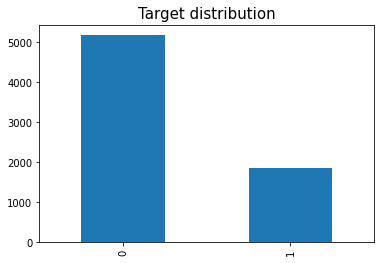

In [17]:
#Look at target distribution
contract['target'].value_counts().plot(kind='bar')
plt.title('Target distribution', size=15)
plt.show()

The target is not balanced, we should: 
1. Replace the accuracy metrics
2. Do upsampling
3. Adjust the weights of the target 1

In [18]:
#Look at descriptive statistics
contract.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80
target,7043.0,0.265370,0.441561,0.00,0.00,0.00,1.00,1.00


Average monthly charge is USD 65 compared to the median of USD 70.<br>
Average total charge is USD 2,283 compared to the median of USD 1,397. <br>

Seems that the montly charges are less volatile than the Total chrages, we will look at their distributions

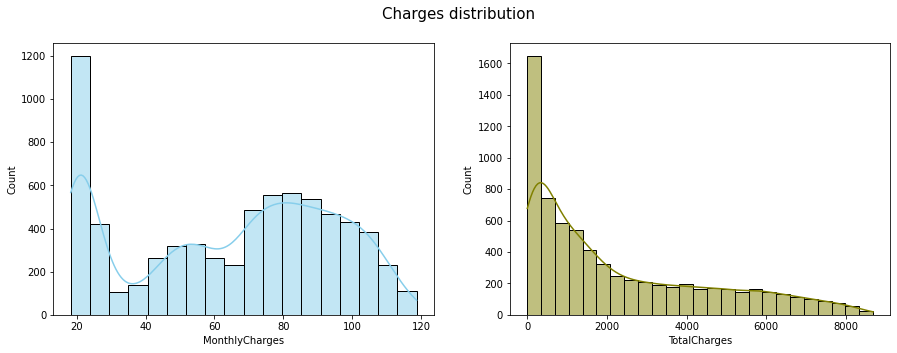

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=contract, x="MonthlyCharges", kde=True, color="skyblue", ax=axs[0])
sns.histplot(data=contract, x="TotalCharges", kde=True,color="olive", ax=axs[1])
fig.suptitle('Charges distribution', size=15)
plt.show()

We see that there is a differernt distribution between the monthly and the total charges. **Total charges** distribution is skewed to the right - we can also see that the mean and the median are very different in there.For **Monthly** charge we see kind of normal distribution with many users paying small amounts.

We need to understand what comprises the total charges.

In [20]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [21]:
#check how many values of leave dates we have
contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

Only 4 dates for users leaving

In [22]:
#Check range of start dates
contract['BeginDate'].describe()

count                    7043
unique                     77
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-02-01 00:00:00
Name: BeginDate, dtype: object

Dates are starting from 2013-01-01 until 2020-01-01

In [23]:
#Create end date of the last date of the file: 2020-02-01
date_until = pd.Timestamp('2020-2-1')

### Changes overtime

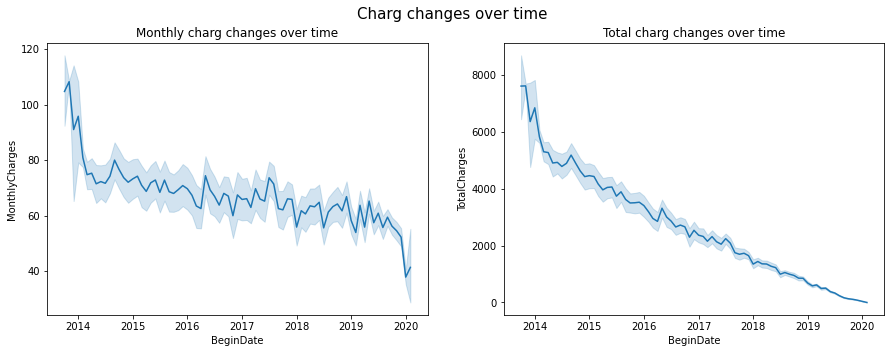

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=contract, x="BeginDate", y="MonthlyCharges", ax=axs[0]).set_title("Monthly charg changes over time")
sns.lineplot(data=contract, x="BeginDate", y="TotalCharges", ax=axs[1]).set_title("Total charg changes over time")
plt.suptitle('Charg changes over time', size=15)
plt.show()

Monthly - We see that the average monthly charge is decreasing for new users.<br>
Total - The total charges are dependent on the seniority of the customers. We expect to see decreasing graph.

In [25]:
#Mean charge for 2014 
contract[contract['BeginDate'].dt.year==2014]['MonthlyCharges'].mean()

76.1337425595237

In [26]:
#Mean charge for 2019 
contract[contract['BeginDate'].dt.year==2019]['MonthlyCharges'].mean()

57.376980071538014

## Number of users overtime

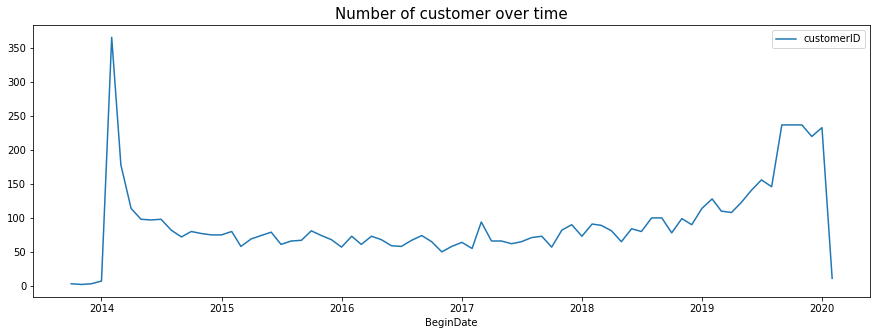

In [27]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.lineplot(data=pd.DataFrame(contract.groupby('BeginDate')['customerID'].nunique()), ax=axs)
plt.title('Number of customer over time', size=15)
plt.show()

We see that the number of custimers is cinstant over time, with snall increase from 2019. The sudden drop in 2020 is due to end of data.

## Feature engineering

### Seniority

In [28]:
#Add seniority - not using EndDate to not create data leakadge 
contract['seniority'] = date_until - contract['BeginDate']

In [29]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,seniority
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,31 days
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,1036 days
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,123 days
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371 days
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,153 days


In [30]:
#Convert days into months
contract['seniority'] = round(contract['seniority']/np.timedelta64(1, 'M'),1)

In [31]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,seniority
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1.0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,34.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,4.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,45.0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,5.0


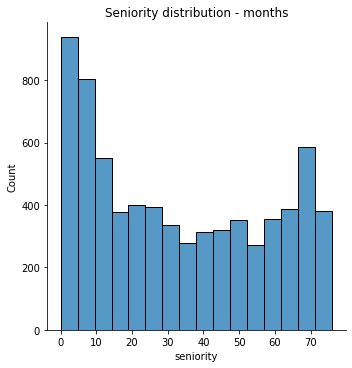

In [32]:
#Look at seniority distribution
sns.displot(contract['seniority'])
plt.title('Seniority distribution - months')
plt.show()

We see that we have more new users than old ones.

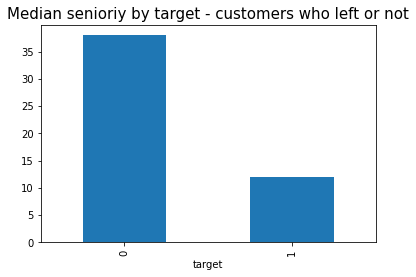

In [33]:
#Exemine seniority for customers who left
contract.groupby('target')['seniority'].median().plot(kind='bar')
plt.title('Median senioriy by target - customers who left or not', size=15)
plt.show()

We see there is a clear differnce between the customers.

### month and year

In [34]:
#Add month and year to maybe recognize some cohort
contract['begin_month'] = contract['BeginDate'].dt.month
contract['begin_year'] = contract['BeginDate'].dt.year
contract['begin_week'] = contract['BeginDate'].dt.week

In [35]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,seniority,begin_month,begin_year,begin_week
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1.0,1,2020,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,34.0,4,2017,13
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,4.0,10,2019,40
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,45.0,5,2016,17
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,5.0,9,2019,35


# EDA

## Bivariant exemination

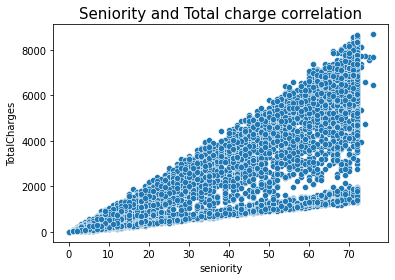

In [36]:
# correlation between seniority and Total charges
sns.scatterplot(data=contract, x="seniority", y="TotalCharges")
plt.title('Seniority and Total charge correlation', size=15)
plt.show()

We see clear pattern between the seniority and the total charge

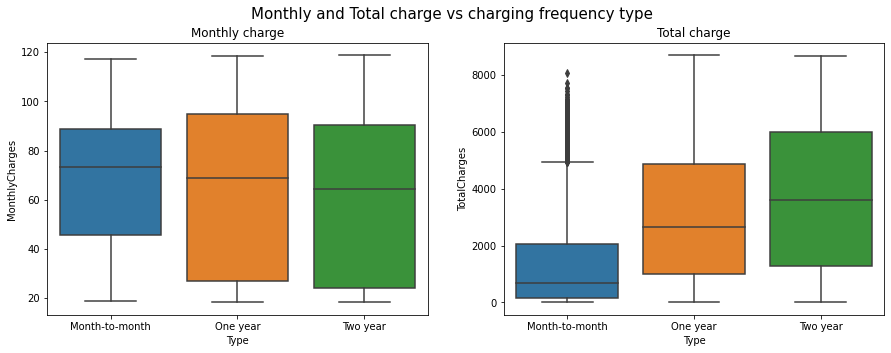

In [37]:
#We also need to change if charges are dependent on other features:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x="Type", y="MonthlyCharges", data=contract, ax=axs[0]).set(title='Monthly charge')
sns.boxplot(x="Type", y="TotalCharges", data=contract, ax=axs[1]).set(title='Total charge')
fig.suptitle('Monthly and Total charge vs charging frequency type', size=15)
plt.show()

Monthly - Users who are charged on a monlthy basis has higher charges and lower varice compared to users under one year contrace and two years contract.<br><br>
Total - Users who has contracts for 2 years have the highest charges compared to monthly charges.

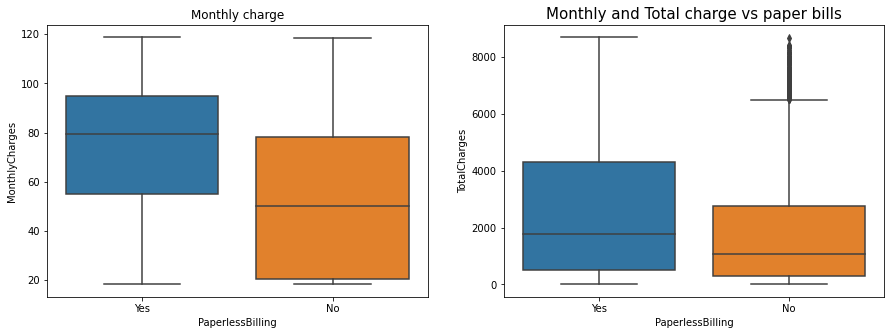

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x="PaperlessBilling", y="MonthlyCharges", data=contract, ax=axs[0]).set(title='Monthly charge')
sns.boxplot(x="PaperlessBilling", y="TotalCharges", data=contract, ax=axs[1]).set(title='Total charge')
plt.title('Monthly and Total charge vs paper bills',size=15)
plt.show()

Users who recive paper bills have higher charges, both in monthly and total charges.

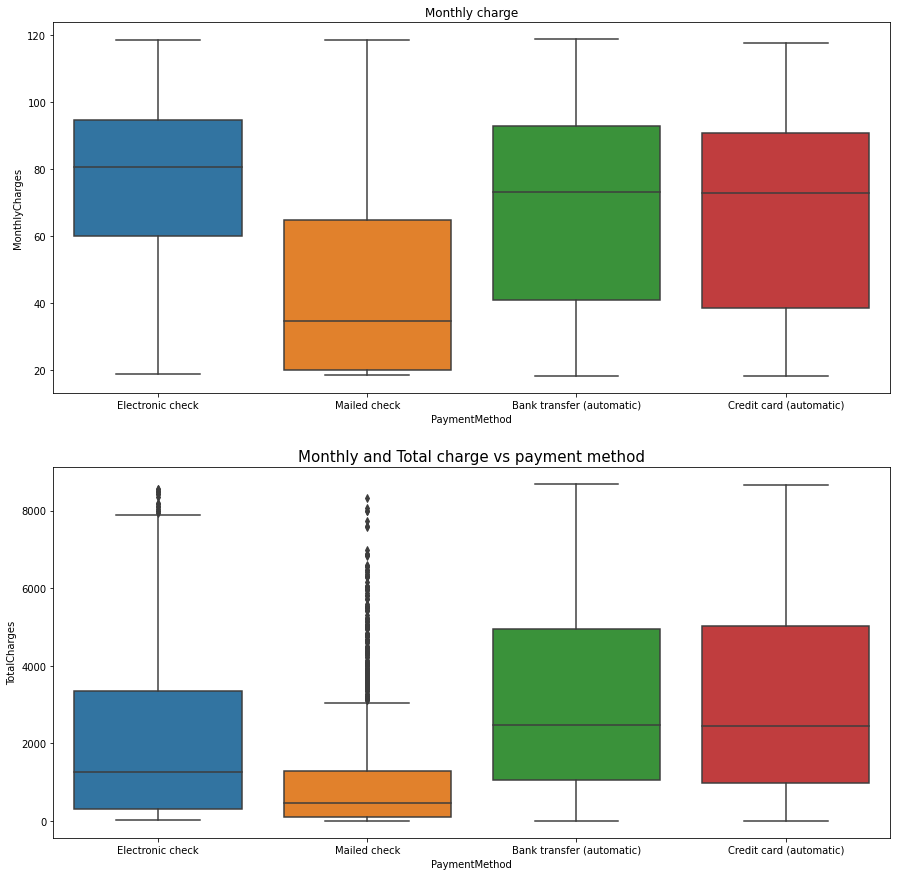

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))
sns.boxplot(x="PaymentMethod", y="MonthlyCharges", data=contract, ax=axs[0]).set(title='Monthly charge')
sns.boxplot(x="PaymentMethod", y="TotalCharges", data=contract, ax=axs[1]).set(title='Total charge')
plt.title('Monthly and Total charge vs payment method',size=15)
plt.show()

Month - Users who pay using electronic chech pay the highest charges. Users who pay by mailed check have the lowest charges.
Total - Users who pay by bank transfer pay the highest charges. Users who pay by mailed check have the lowest charges.

In [40]:
#Check for duplicated rows
contract.duplicated().sum()

0

In [41]:
#Convert Yes/No to 1 and 0
contract.replace(to_replace =['No','Yes'], value =[0,1], inplace=True)

## internet

In [42]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [43]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


We have less observations in this table. Probably not all users have internet service.

In [44]:
#check for duplicated users
internet['customerID'].duplicated().sum()

0

In [45]:
internet.describe(include='all').T

,count,unique,top,freq
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


We have two internet services and other boolean variables.

In [46]:
#Check what are the internet services:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

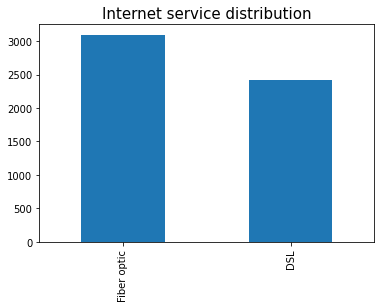

In [47]:
#Check what are the internet services:
internet['InternetService'].value_counts().plot(kind='bar')
plt.title('Internet service distribution', size=15)
plt.show()

We have more fiber users than DSL

We will replace all 'No' values with 0 and 'Yes' values with 1.

In [48]:
#See the columns
internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [49]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [50]:
internet.replace(to_replace =['No','Yes'], value =[0,1], inplace=True)

In [51]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0


In [52]:
internet.groupby('InternetService')[['OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].sum()

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
InternetService,,,,,,
DSL,1180,1086,1065,1178,957,981
Fiber optic,839,1343,1357,866,1750,1751


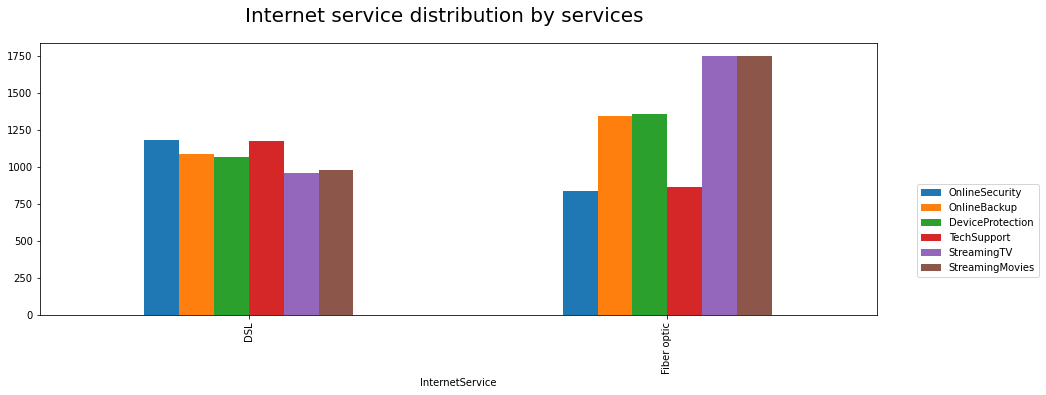

In [53]:
fig, axs = plt.subplots(figsize=(15, 5))
internet.groupby('InternetService')[['OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].sum().plot(kind='bar', ax=axs).legend(bbox_to_anchor=(1.2, 0.5))
plt.suptitle('Internet service distribution by services', size=20)
plt.show()

We can see that internet services are different between DSL and Fiber optic. For customers using DSL, the largest service is Online security while for users who have Fiber, the most frequent services are StreamingTV and streaming Movies, probabliy because the speed is very stable.

### Feature engineering

In [54]:
#Adding feature - total online services
internet['total_int_serv'] = internet[['OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].sum(axis=1)

In [55]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,total_int_serv
0,7590-VHVEG,DSL,0,1,0,0,0,0,1
1,5575-GNVDE,DSL,1,0,1,0,0,0,2
2,3668-QPYBK,DSL,1,1,0,0,0,0,2
3,7795-CFOCW,DSL,1,0,1,1,0,0,3
4,9237-HQITU,Fiber optic,0,0,0,0,0,0,0


## personal

In [56]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [57]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [58]:
#Check for duplicated users
personal['customerID'].duplicated().sum()

0

In [59]:
#Replace yes/No with int
personal.replace(to_replace =['No','Yes'], value =[0,1], inplace=True)

In [60]:
#Replace Female/MAle with int
personal.replace(to_replace =['Female','Male'], value =[0,1], inplace=True)

In [61]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0


In [62]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   int64 
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   int64 
 4   Dependents     7043 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 275.2+ KB


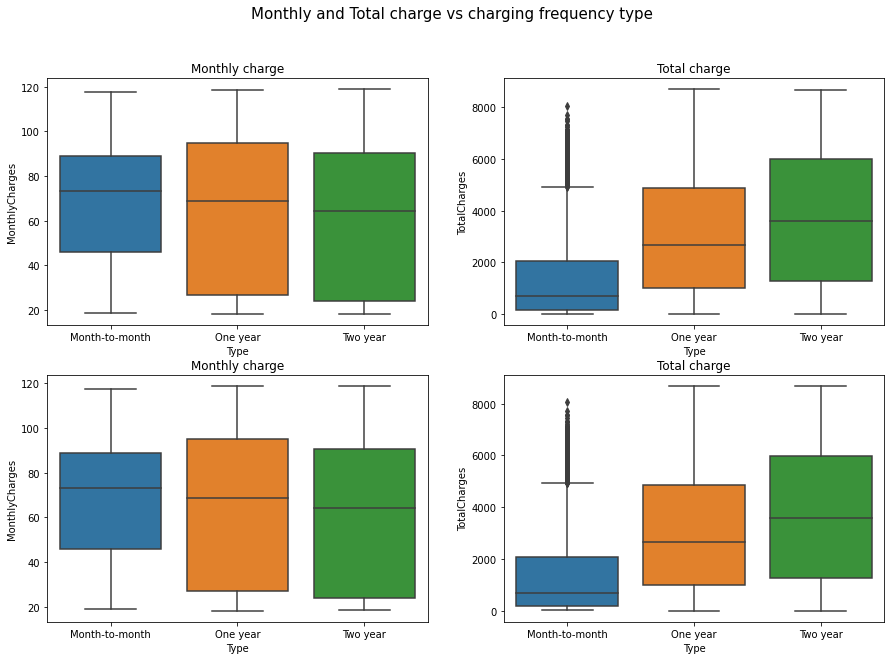

In [63]:
#We also need to change if charges are dependent on other features:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x="Type", y="MonthlyCharges", data=contract, ax=axs[0,0]).set(title='Monthly charge')
sns.boxplot(x="Type", y="TotalCharges", data=contract, ax=axs[0,1]).set(title='Total charge')
sns.boxplot(x="Type", y="MonthlyCharges", data=contract, ax=axs[1,0]).set(title='Monthly charge')
sns.boxplot(x="Type", y="TotalCharges", data=contract, ax=axs[1,1]).set(title='Total charge')
fig.suptitle('Monthly and Total charge vs charging frequency type', size=15)
plt.show()

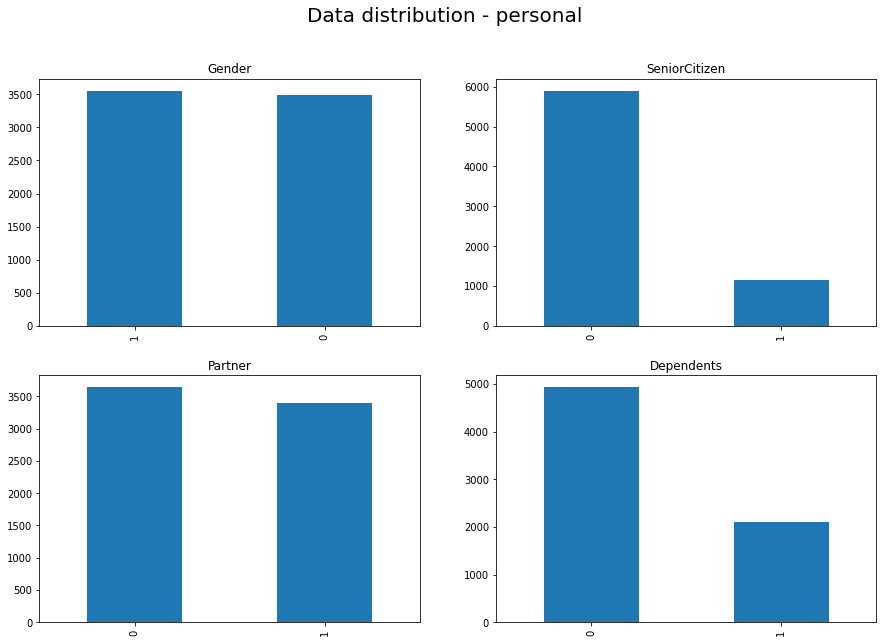

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
personal['gender'].value_counts().plot(kind='bar', ax=axs[0,0]).set(title='Gender')
personal['SeniorCitizen'].value_counts().plot(kind='bar', ax=axs[0,1]).set(title='SeniorCitizen')
personal['Partner'].value_counts().plot(kind='bar', ax=axs[1,0]).set(title='Partner')
personal['Dependents'].value_counts().plot(kind='bar', ax=axs[1,1]).set(title='Dependents')
plt.suptitle('Data distribution - personal',size=20)
plt.show()

In this data we see similar proportion of men and women, and also single vs parter. we see small portion of cenior citizens and smal number of users wit hchildren.

## phone

In [65]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [66]:
#Check for duplicated users
phone['customerID'].duplicated().sum()

0

In [67]:
#Replace yes/No with int
phone.replace(to_replace =['No','Yes'], value =[0,1], inplace=True)

In [68]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.5+ KB


In [69]:
phone['MultipleLines'].value_counts()

0    3390
1    2971
Name: MultipleLines, dtype: int64

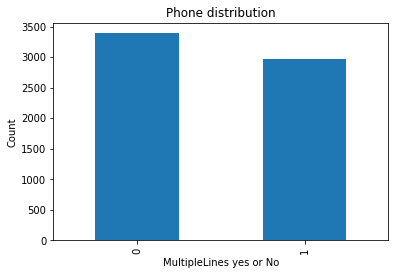

In [70]:
phone['MultipleLines'].value_counts().plot(kind='bar')
plt.title('Phone distribution')
plt.xlabel('MultipleLines yes or No')
plt.ylabel('Count')
plt.show()

In [71]:
#number of users in each table
print('contract:',len(contract), 'internet:',len(internet), 'personal:',len(personal), 'phone:',len(phone))

contract: 7043 internet: 5517 personal: 7043 phone: 6361


# Work Plan

1. Preprocessing and EDA of the data as prepared above, follwing by merging all tables into the main DataFrame. As we have different number of users under different services (internet and phone), after merging the tables we expect to have NA's for users who have no additional services - we will replace this Yes/No NA's with 0 and Internet service NA's with category of 'No service'.<br><br>

2. During the EDA stage we also did feature engineering: Seniority of the customer (Feb 1, 2020 - Start date), Year, month, week, average charge (Total charge/seniority). Additional feature engineering will be exemined after getting the results.<br><br>

3. Data encoding: We have categorical features that will be encoded using OHE to create dummy variables which can be used in Logistic regression and other models. Categorical variables: Type and PaymentMethod. We will drop the first category in each feature to avoid multicolinieriy.<br><br>

4. Check correlation between variables to avoid multicolinearity.<br><br>

5. Normalize the data - we will normalize the data (mean=0, sd=1) as we intend to use models which are sensetive to scaling such as SVM.<br><br>

6. Split the data: We created new target feature, 1 if customer left and 0 otherwise. We will drop the EndDate column to avoid data leakedge and use the target columns as the target and all others as features. We will drop the userID column which is not adding any new information and there is no need to learn anything about specific customer. We will also drop the BeginDate columns as date can't be used in this format. We will then split the data into train (80%) and test (20%). The train set will be used with Cross Validation to exemine the results on validation set.<br><br>

7. Imbalanced data - we will exemine the reuslt using tuning hyperparameters for balanced weights or upsampling method.<br><br>

8. Build a function that will get a model, set of param and run GridSearch with CV. The models we will use: Logistic regression as a baseline, SVM, Random forest, XGBoost and LightGBM.<br><br>

9. Evaluation of the result: We will exemine confision matrix to understnd the results and compatre the results of AUC ROC of train and validation set and the reuslt to our goal, to understand if we need to improve the model or add regularization or add feautres. In addition we will look at feature imprtance and SHAP in order to understand what are the most important feautres.

## Merge tables

In [72]:
#we will use outer join to make sure we have no users in the service and personal tables that are not in the contract table
data = contract.merge(personal, how='outer', on='customerID')

In [73]:
data = data.merge(internet, how='outer', on='customerID' )

In [74]:
data = data.merge(phone, how='outer', on='customerID' )

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   target            7043 non-null   int64         
 9   seniority         7043 non-null   float64       
 10  begin_month       7043 non-null   int64         
 11  begin_year        7043 non-null   int64         
 12  begin_week        7043 non-null   int64         
 13  gender            7043 non-null   int64         
 14  SeniorCitizen     7043 n

In [76]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,seniority,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,total_int_serv,MultipleLines
0,7590-VHVEG,2020-01-01,0,Month-to-month,1,Electronic check,29.85,29.85,0,1.0,...,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN
1,5575-GNVDE,2017-04-01,0,One year,0,Mailed check,56.95,1889.50,0,34.0,...,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,1,4.0,...,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
3,7795-CFOCW,2016-05-01,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,45.0,...,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,3.0,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,1,5.0,...,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We expect to see 7,043 customers after merge.

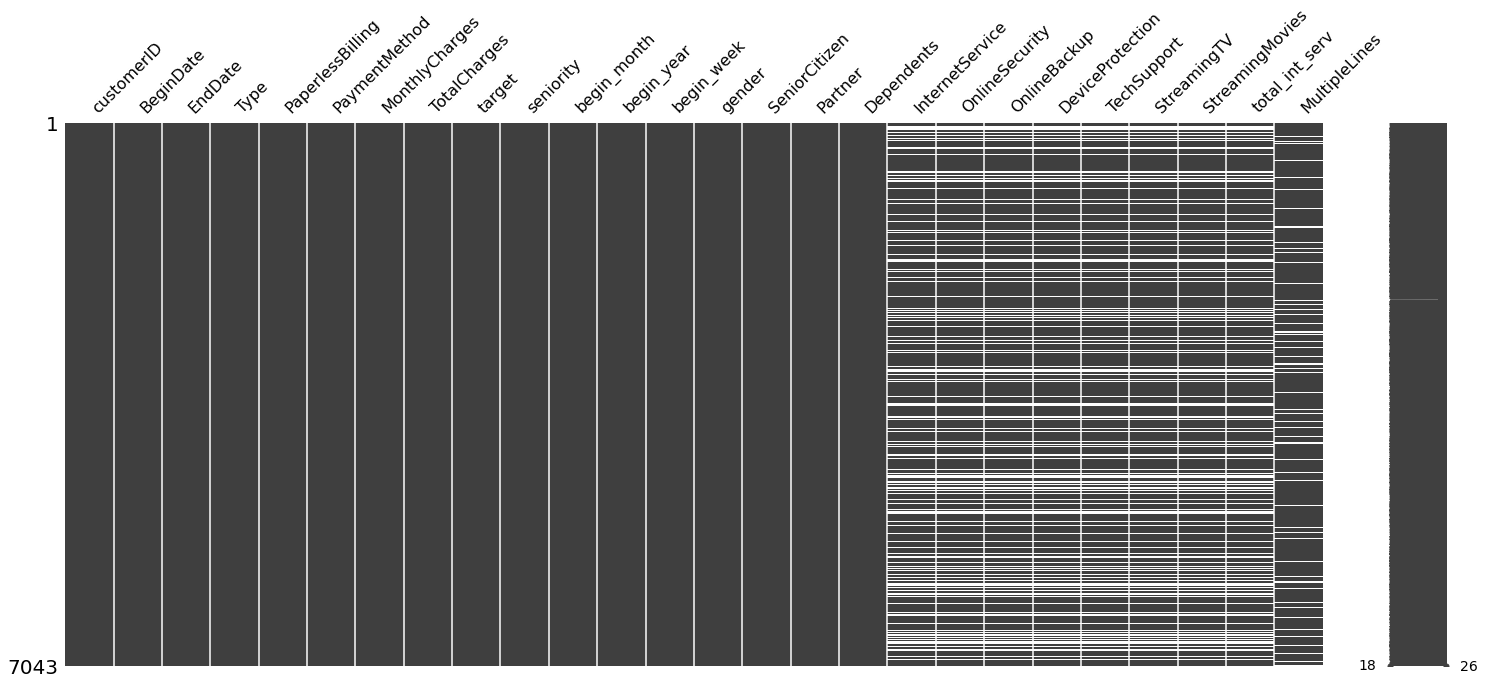

In [77]:
#Look at missing values
msno.matrix(data);

## Missing vales

We will replace all missing values for services with 0 and missing values for internet service with 'No_service'

In [78]:
data['InternetService'].fillna('No_service', inplace=True)

In [79]:
#Get columns for replacment
nacolumns = internet.columns[2:]
nacolumns

Index(['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'total_int_serv'],
      dtype='object')

In [80]:
#replace NA with 0 (no service)
for i in nacolumns:
    data[i].fillna(0, inplace=True)

In [81]:
data['MultipleLines'].fillna(0, inplace=True)

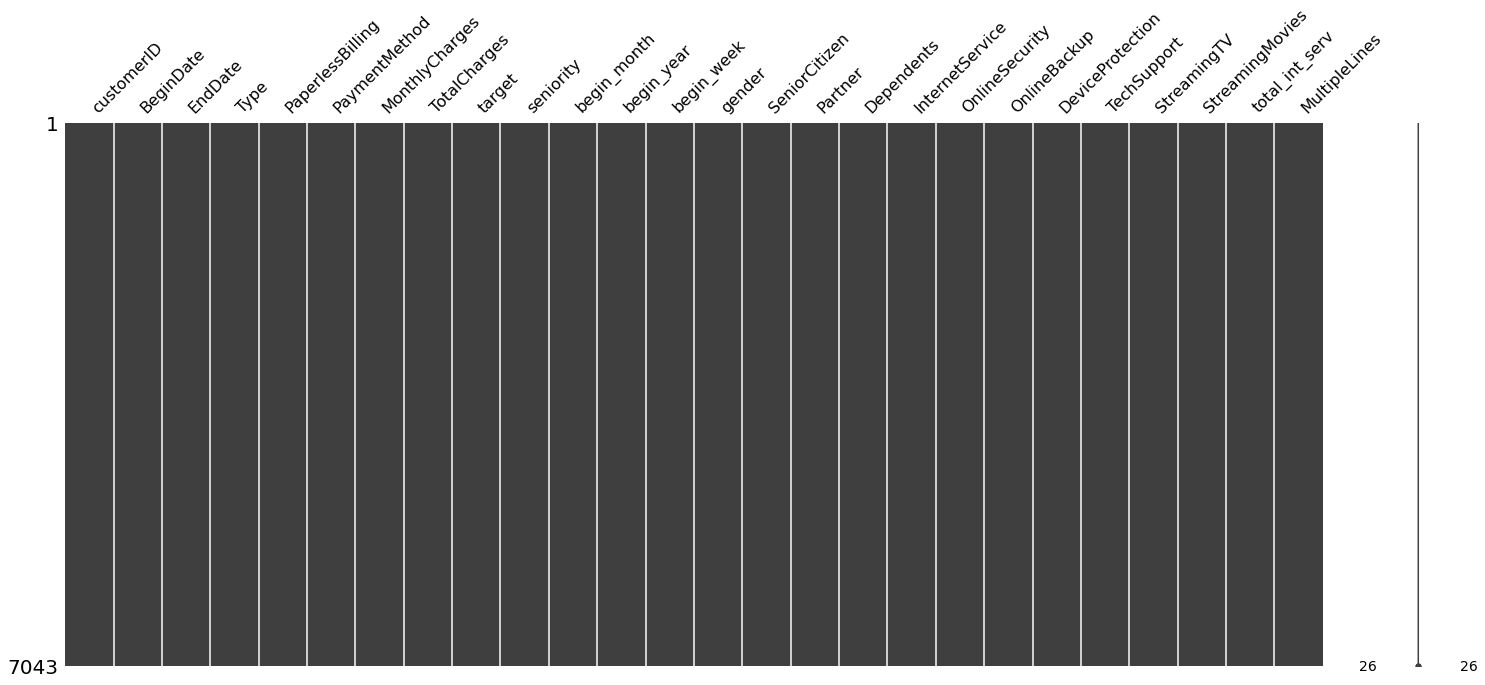

In [82]:
#Look at missing values
msno.matrix(data);

We replaced all NA.

## Encoding

We will use OHE to convert categorical variables into dummy variables, with drop first to avoid multicolinearity. <br>
Categorical variables are: Type, PaymentMethod and InternetService.

As there are only small number of categories in these variables we will encode the data before splitting into train and test.

In [83]:
data.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'target',
       'seniority', 'begin_month', 'begin_year', 'begin_week', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'total_int_serv', 'MultipleLines'],
      dtype='object')

In [84]:
cat_var = ['Type','PaymentMethod','InternetService']

In [85]:
encoder = OneHotEncoder(drop='first', sparse = False)

In [86]:
cat_var_ohe = encoder.fit_transform(data[cat_var])

In [87]:
#Create list of categories names after droping the first one
columns_ohe = encoder.categories_[0].tolist()[1:3]+encoder.categories_[1].tolist()[1:4]+encoder.categories_[2].tolist()[1:3]
columns_ohe

['One year',
 'Two year',
 'Credit card (automatic)',
 'Electronic check',
 'Mailed check',
 'Fiber optic',
 'No_service']

In [88]:
ohe_data = pd.DataFrame(cat_var_ohe, columns=columns_ohe)
ohe_data.head()

,One year,Two year,Credit card (automatic),Electronic check,Mailed check,Fiber optic,No_service
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [89]:
#Merge the encoded data with the original
data = data.merge(ohe_data, left_index=True, right_index=True)

In [90]:
#Drop all columns that won't be needed - categorical, customerID, dates columns
data = data.drop(['customerID','BeginDate','EndDate','Type','PaymentMethod','InternetService'], axis=1)

In [91]:
#See the data
data.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,target,seniority,begin_month,begin_year,begin_week,gender,SeniorCitizen,...,StreamingMovies,total_int_serv,MultipleLines,One year,Two year,Credit card (automatic),Electronic check,Mailed check,Fiber optic,No_service
0,1,29.85,29.85,0,1.0,1,2020,1,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,56.95,1889.50,0,34.0,4,2017,13,1,0,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,53.85,108.15,1,4.0,10,2019,40,1,0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,42.30,1840.75,0,45.0,5,2016,17,1,0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,70.70,151.65,1,5.0,9,2019,35,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PaperlessBilling         7043 non-null   int64  
 1   MonthlyCharges           7043 non-null   float64
 2   TotalCharges             7043 non-null   float64
 3   target                   7043 non-null   int64  
 4   seniority                7043 non-null   float64
 5   begin_month              7043 non-null   int64  
 6   begin_year               7043 non-null   int64  
 7   begin_week               7043 non-null   int64  
 8   gender                   7043 non-null   int64  
 9   SeniorCitizen            7043 non-null   int64  
 10  Partner                  7043 non-null   int64  
 11  Dependents               7043 non-null   int64  
 12  OnlineSecurity           7043 non-null   float64
 13  OnlineBackup             7043 non-null   float64
 14  DeviceProtection        

No missing values and no categorical values.

## Correlation

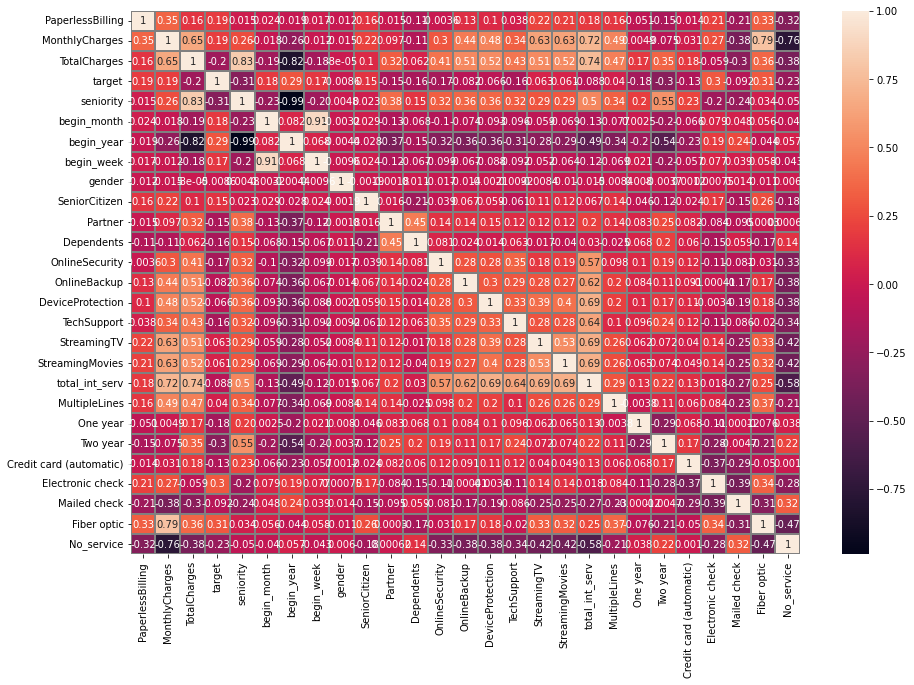

In [93]:
fig, axs = plt.subplots(figsize=(15, 10))
sns.heatmap(data.corr(), ax=axs, linewidths=.01,linecolor='gray',annot=True)
plt.show()

Begin year and seniority is very correlated, 0.99 - we will drop the seniority column

In [94]:
#Drop seniority
data = data.drop(['seniority'], axis=1)

## Normalization

We will normalize the data inside a pipeline to use it in GridSearchCV

# Data split

In [95]:
target = data['target']
features = data.drop(['target'], axis=1)

In [96]:
#split into 80% (will be used with cross validation) train and 20% test
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Imbalanced data

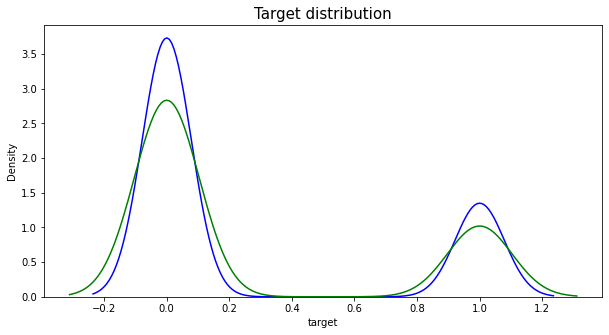

In [97]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=target_train, ax=axs, color='blue')
sns.kdeplot(data=target_test, ax=axs, color='green')
plt.title('Target distribution', size=15)
plt.show()

## Pipeline

We will use pipeline to upsample the train set and normalize data while doing cross validation.

## GridSearchCV

In [98]:
def best_model(pipeline, parm, x_train, y_train):
    model_grid = GridSearchCV(pipeline, parm, cv=5, verbose=5, refit=True, scoring = 'roc_auc')
    model_grid.fit(x_train, y_train)
    print()
    print('Best parameters:', model_grid.best_params_)
    print()
    print('Best score:', round(model_grid.best_score_,2))
    return model_grid

In [99]:
#Create empty tuple for score
models_score = {}

## Logistic Regression

In [100]:
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('scaler',StandardScaler()), ('model',LogisticRegression())])

log_reg = best_model(pipe, {}, features_train, target_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.848 total time=   0.0s
[CV 2/5] END ..................................., score=0.842 total time=   0.0s
[CV 3/5] END ..................................., score=0.829 total time=   0.0s
[CV 4/5] END ..................................., score=0.827 total time=   0.0s
[CV 5/5] END ..................................., score=0.832 total time=   0.0s

Best parameters: {}

Best score: 0.84


### Exemine on test data

In [101]:
#The prediction skips the upsampling part
y_pred = log_reg.predict(features_test)

test_lr_auc = round(roc_auc_score(target_test, log_reg.predict_proba(features_test)[:, 1]),2)

print('Test AUC ROC:',test_lr_auc)

Test AUC ROC: 0.86


In [102]:
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82      1036
           1       0.53      0.82      0.64       373

    accuracy                           0.76      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.76      0.77      1409



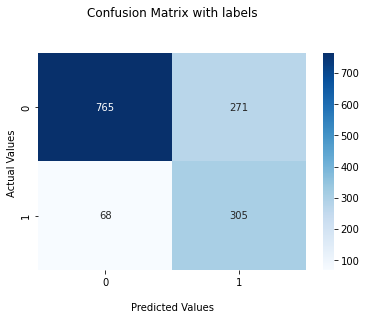

In [103]:
conf_matrix = confusion_matrix(target_test, y_pred)

ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels([0,1])
ax.set_yticklabels([0,1])
plt.show()

In [104]:
models_score['Logistic_regression'] = [log_reg.best_score_,test_lr_auc]

## SVM

In [105]:
%%time

# C - Regularization parameter. The strength of the regularization is inversely proportional to C. 
#Must be strictly positive. The penalty is a squared l2 penalty.

# gamma - The gamma parameters can be seen as the inverse of the radius of influence of 
#samples selected by the model as support vectors. When gamma is very small, the model is too constrained and cannot capture 
#the complexity or “shape” of the data. 
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('scaler',StandardScaler()), ('model',SVC())])

param_grid = {'model__C': [0.1, 1000],
              'model__gamma': [1,  0.01],
              'model__kernel': ['rbf'], 'model__probability':[True]}

svc = best_model(pipe, param_grid, features_train, target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END model__C=0.1, model__gamma=1, model__kernel=rbf, model__probability=True;, score=0.736 total time=  14.1s
[CV 2/5] END model__C=0.1, model__gamma=1, model__kernel=rbf, model__probability=True;, score=0.726 total time=  15.3s
[CV 3/5] END model__C=0.1, model__gamma=1, model__kernel=rbf, model__probability=True;, score=0.730 total time=  15.3s
[CV 4/5] END model__C=0.1, model__gamma=1, model__kernel=rbf, model__probability=True;, score=0.723 total time=  15.1s
[CV 5/5] END model__C=0.1, model__gamma=1, model__kernel=rbf, model__probability=True;, score=0.737 total time=  15.0s
[CV 1/5] END model__C=0.1, model__gamma=0.01, model__kernel=rbf, model__probability=True;, score=0.845 total time=  10.0s
[CV 2/5] END model__C=0.1, model__gamma=0.01, model__kernel=rbf, model__probability=True;, score=0.844 total time=   9.9s
[CV 3/5] END model__C=0.1, model__gamma=0.01, model__kernel=rbf, model__probability=True;, score=0.83

In [106]:
y_pred_svc = svc.predict(features_test)

test_scv_auc = round(roc_auc_score(target_test, svc.predict_proba(features_test)[:, 1]),2)

print('Test AUC ROC:',test_scv_auc)

Test AUC ROC: 0.93


In [107]:
print(classification_report(target_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1036
           1       0.76      0.81      0.78       373

    accuracy                           0.88      1409
   macro avg       0.84      0.86      0.85      1409
weighted avg       0.88      0.88      0.88      1409



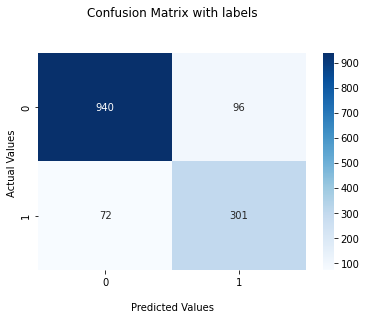

In [108]:
conf_matrix_svc = confusion_matrix(target_test, y_pred_svc)

ax = sns.heatmap(conf_matrix_svc, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels([0,1])
ax.set_yticklabels([0,1])
plt.show()

In [109]:
models_score['SVC'] = [svc.best_score_,test_scv_auc]

## Random Forest

In [110]:
%%time
# n_estimators - This is the number of trees
# max_depth - The maximum depth of the tree. Need to restriced to avoid overfitting
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('scaler',StandardScaler()), ('model',RandomForestClassifier(random_state=12345))])

rf = best_model(pipe, {'model__n_estimators' : [100, 200],
                        'model__max_depth' : [20,50]}, features_train, target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END model__max_depth=20, model__n_estimators=100;, score=0.898 total time=   0.5s
[CV 2/5] END model__max_depth=20, model__n_estimators=100;, score=0.881 total time=   0.5s
[CV 3/5] END model__max_depth=20, model__n_estimators=100;, score=0.875 total time=   0.5s
[CV 4/5] END model__max_depth=20, model__n_estimators=100;, score=0.875 total time=   0.5s
[CV 5/5] END model__max_depth=20, model__n_estimators=100;, score=0.881 total time=   0.5s
[CV 1/5] END model__max_depth=20, model__n_estimators=200;, score=0.897 total time=   1.2s
[CV 2/5] END model__max_depth=20, model__n_estimators=200;, score=0.882 total time=   1.2s
[CV 3/5] END model__max_depth=20, model__n_estimators=200;, score=0.877 total time=   1.1s
[CV 4/5] END model__max_depth=20, model__n_estimators=200;, score=0.877 total time=   1.1s
[CV 5/5] END model__max_depth=20, model__n_estimators=200;, score=0.881 total time=   1.1s
[CV 1/5] END model__max_depth=

In [111]:
y_pred_rf = rf.predict(features_test)

test_rf_auc = round(roc_auc_score(target_test, rf.predict_proba(features_test)[:, 1]),2)

print('Test AUC ROC:',test_rf_auc)

Test AUC ROC: 0.91


In [112]:
print(classification_report(target_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1036
           1       0.77      0.68      0.72       373

    accuracy                           0.86      1409
   macro avg       0.83      0.80      0.81      1409
weighted avg       0.86      0.86      0.86      1409



In [113]:
models_score['RandomForest'] = [rf.best_score_,test_rf_auc]

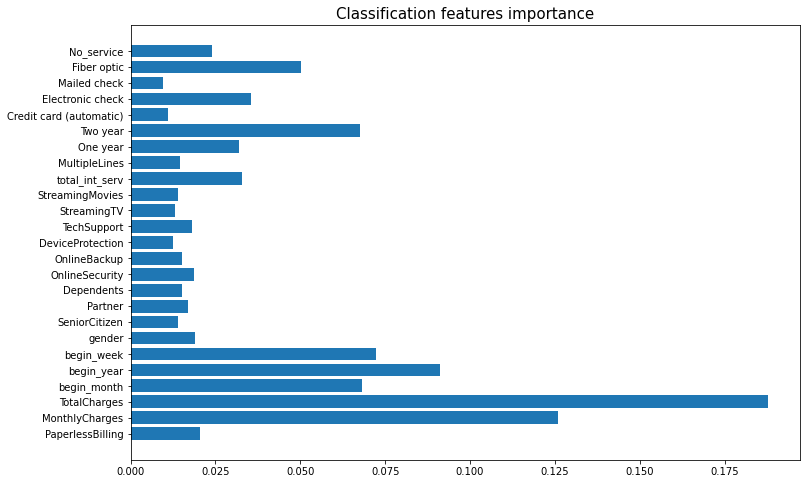

In [114]:
fig, axs = plt.subplots(figsize=(12, 8))
plt.barh(features_test.columns, rf.best_estimator_._final_estimator.feature_importances_)
plt.title('Classification features importance', size=15)
plt.show()

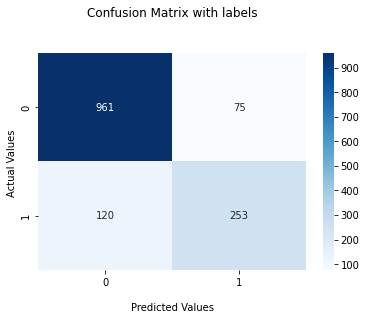

In [115]:
conf_matrix_rf = confusion_matrix(target_test, y_pred_rf)

ax = sns.heatmap(conf_matrix_rf, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels([0,1])
ax.set_yticklabels([0,1])
plt.show()

## XGBoost

In [116]:
%%time
# n_estimators - number of boosting rounds that will be performed
# max_depth -  maximum distance between the root node of each tree and a leaf node

pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('scaler',StandardScaler()), ('model',XGBClassifier(random_state=12345))])

xgboost = best_model(pipe, {
                        'model__learning_rate' : [0.01, 0.1],
                        'model__n_estimators' : [100, 200],
                        'model__max_depth' : [20, 50],
                        'model__objective':['binary:logistic'],
                        'model__eval_metric':['auc']}, features_train, target_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END model__eval_metric=auc, model__learning_rate=0.01, model__max_depth=20, model__n_estimators=100, model__objective=binary:logistic;, score=0.888 total time=   1.8s
[CV 2/5] END model__eval_metric=auc, model__learning_rate=0.01, model__max_depth=20, model__n_estimators=100, model__objective=binary:logistic;, score=0.879 total time=   2.1s
[CV 3/5] END model__eval_metric=auc, model__learning_rate=0.01, model__max_depth=20, model__n_estimators=100, model__objective=binary:logistic;, score=0.876 total time=   1.4s
[CV 4/5] END model__eval_metric=auc, model__learning_rate=0.01, model__max_depth=20, model__n_estimators=100, model__objective=binary:logistic;, score=0.874 total time=   1.5s
[CV 5/5] END model__eval_metric=auc, model__learning_rate=0.01, model__max_depth=20, model__n_estimators=100, model__objective=binary:logistic;, score=0.880 total time=   3.7s
[CV 1/5] END model__eval_metric=auc, model__learning_rate=0.

In [117]:
y_pred_xgb = xgboost.predict(features_test)

test_xgboost_auc = round(roc_auc_score(target_test, xgboost.predict_proba(features_test)[:, 1]),2)

print('Test AUC ROC:',test_xgboost_auc)

Test AUC ROC: 0.93


In [118]:
models_score['XGBoost'] = [xgboost.best_score_, test_xgboost_auc]

## LightGBM

In [119]:
%%time
# n_estimators - number of boosting rounds that will be performed
# max_depth -  maximum distance between the root node of each tree and a leaf node
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('scaler',StandardScaler()), ('model',lgb.LGBMClassifier(random_state=12345))])

lgbm = best_model(pipe, {'model__learning_rate' : [0.01, 0.1],
                        'model__n_estimators' : [100, 200],
                        'model__max_depth' : [20, 50]}, features_train, target_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END model__learning_rate=0.01, model__max_depth=20, model__n_estimators=100;, score=0.891 total time=   0.1s
[CV 2/5] END model__learning_rate=0.01, model__max_depth=20, model__n_estimators=100;, score=0.882 total time=   0.1s
[CV 3/5] END model__learning_rate=0.01, model__max_depth=20, model__n_estimators=100;, score=0.872 total time=   0.1s
[CV 4/5] END model__learning_rate=0.01, model__max_depth=20, model__n_estimators=100;, score=0.870 total time=   0.1s
[CV 5/5] END model__learning_rate=0.01, model__max_depth=20, model__n_estimators=100;, score=0.889 total time=   0.1s
[CV 1/5] END model__learning_rate=0.01, model__max_depth=20, model__n_estimators=200;, score=0.895 total time=   0.3s
[CV 2/5] END model__learning_rate=0.01, model__max_depth=20, model__n_estimators=200;, score=0.889 total time=   0.3s
[CV 3/5] END model__learning_rate=0.01, model__max_depth=20, model__n_estimators=200;, score=0.884 total time=   0

In [120]:
y_pred_lgbm = lgbm.predict(features_test)

test_lgbm_auc = round(roc_auc_score(target_test, lgbm.predict_proba(features_test)[:, 1]),2)

print('Test AUC ROC:',test_lgbm_auc)

Test AUC ROC: 0.94


In [121]:
print(classification_report(target_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1036
           1       0.80      0.80      0.80       373

    accuracy                           0.89      1409
   macro avg       0.86      0.86      0.86      1409
weighted avg       0.89      0.89      0.89      1409



In [122]:
models_score['LightGBM'] = [lgbm.best_score_, test_lgbm_auc]

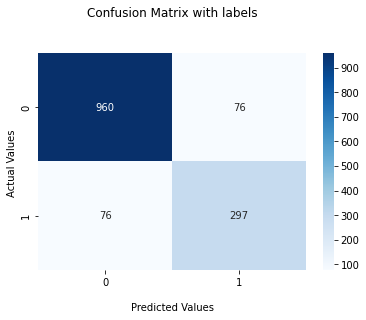

In [123]:
#confusion_matrix
conf= confusion_matrix(target_test, y_pred_lgbm)

ax = sns.heatmap(conf, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels([0,1])
ax.set_yticklabels([0,1])
plt.show()

## Scores

In [124]:
pd.DataFrame.from_dict(models_score, orient='index', columns=['Train AUC ROC', 'Test AUC ROC']).sort_values(by='Test AUC ROC', ascending=False)

,Train AUC ROC,Test AUC ROC
LightGBM,0.910156,0.94
SVC,0.915193,0.93
XGBoost,0.904939,0.93
RandomForest,0.883154,0.91
Logistic_regression,0.835602,0.86


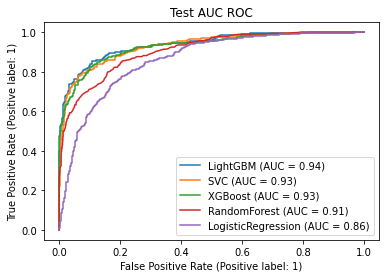

In [125]:
ax = plt.gca()
plt.title('Test AUC ROC')
metrics.plot_roc_curve(lgbm, features_test, target_test, name = 'LightGBM', ax=ax)
metrics.plot_roc_curve(svc, features_test, target_test, ax=ax, name ='SVC')
metrics.plot_roc_curve(xgboost, features_test, target_test, ax=ax, name ='XGBoost')
metrics.plot_roc_curve(rf, features_test, target_test, ax=ax, name ='RandomForest')
metrics.plot_roc_curve(log_reg, features_test, target_test, ax=ax, name ='LogisticRegression')
plt.show()


In [126]:
#Classification report for SVC
print(classification_report(target_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1036
           1       0.80      0.80      0.80       373

    accuracy                           0.89      1409
   macro avg       0.86      0.86      0.86      1409
weighted avg       0.89      0.89      0.89      1409



F1 score for 1 seems to be low, 80% but AUC ROC is high 94%.<br>
Average F1 score is 89%.

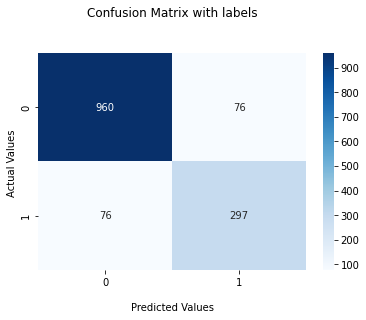

In [127]:
#confusion_matrix
conf= confusion_matrix(target_test, y_pred_lgbm)

ax = sns.heatmap(conf, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels([0,1])
ax.set_yticklabels([0,1])
plt.show()

## Conclusion

For churn prediction we were able to get 94% AUC ROC and 88% F1 score. Meaning, the customers or the marketing department would be able to approach the customer who is about to leave and sugest some benefits. When these benefits will be lower than customer aquisition costs, the company will benefit. This problem is solved using LightGBM, with the target of 88% AUC ROC for the test set. Looking at the feature importance of Random Forest model we see that the most important features are total charges in the customer lifetime and the monthly charges.